In [1]:
import os
os.chdir('../')
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Helper class which makes building relatively high D Gaussians fast

In [3]:
class HighDimensionalNormalLogPDF(pints.LogPDF):
    def __init__(self, dimension, correlation):
        self._dimension = int(dimension)
        self._correlation = correlation
        # Construct mean array
        self._mean = np.zeros(self._dimension)

        # Construct covariance matrix where diagonal variances = i
        # and off-diagonal covariances = 0.5 * sqrt(i) * sqrt(j)
        cov = np.arange(1, 1 + self._dimension).reshape((self._dimension, 1))
        cov = cov.repeat(self._dimension, axis=1)
        cov = np.sqrt(cov)
        cov = correlation * cov * cov.T
        np.fill_diagonal(cov, 1 + np.arange(self._dimension))
        self._sigma = cov
        self._sd = 1 + np.arange(self._dimension)

        # Construct scipy 'random variable'
        self._var = pints.toy.NormalLogPDF(self._mean, self._sigma)

    def __call__(self, x):
        return self._var(x)

    def n_parameters(self):
        """ See :meth:`pints.LogPDF.n_parameters()`. """
        return self._dimension

    def covariance_matrix(self):
        """
        Returns covariance matrix.
        """
        return self._sigma
    
    def kl_divergence(self, samples):
        m0 = np.mean(samples, axis=0)
        m1 = self._mean
        s0 = np.cov(samples.T)
        s1 = self._sigma
        cov_inv = np.linalg.inv(s1)

        dkl1 = np.trace(cov_inv.dot(s0))
        dkl2 = np.dot((m1 - m0).T, cov_inv).dot(m1 - m0)
        dkl3 = np.log(np.linalg.det(s1) / np.linalg.det(s0))
        return 0.5 * (dkl1 + dkl2 + dkl3 - self._dimension)
    
n_chains = 4
samplers = [pints.AdaptiveCovarianceMCMC, pints.DreamMCMC,
            pints.MetropolisRandomWalkMCMC, pints.DifferentialEvolutionMCMC,
            pints.PopulationMCMC]
samplesizes = [2000, 2000, 2000, 10000, 10000]

def run_samplers(a_dist, samplers, samplesizes, n_chains):
    names = []
    kls = np.zeros(len(samplers))
    for i, sampler in enumerate(samplers):
        x0 = np.zeros(a_dist.n_parameters()) + np.random.normal(0, 1, size=(n_chains, a_dist.n_parameters()))
        mcmc = pints.MCMCSampling(a_dist, n_chains, x0, method=sampler)
        mcmc.set_log_to_screen(False)
        mcmc.set_max_iterations(samplesizes[i])
        chains = mcmc.run()
        chains = chains[:, int(samplesizes[i] / 2):, :]
        chain = np.vstack(chains)
        kls[i] = a_dist.kl_divergence(chain)
        name = mcmc.samplers()[0].name()
        names.append(name)
        print(name)
    return kls, names

# Two dimensional weakly correlated Gaussian

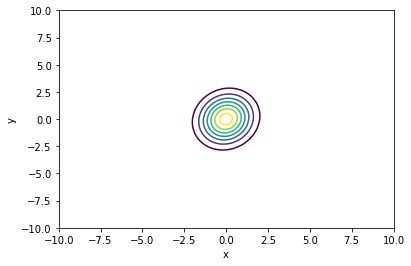

In [3]:
a_dist = HighDimensionalNormalLogPDF(2, 0.1)

levels = np.linspace(-10,10,10)
num_points = 100
x = np.linspace(-10, 10, num_points)
y = np.linspace(-10, 10, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[a_dist([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC
Differential Evolution MCMC
Population MCMC


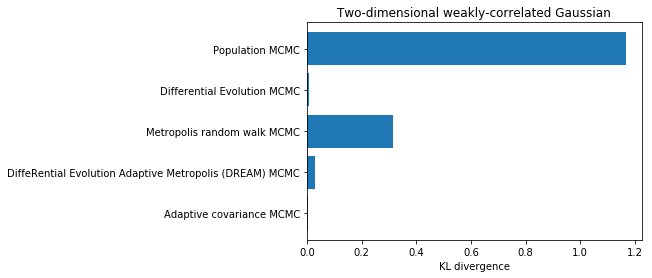

In [4]:
kls, names = run_samplers(a_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(kls)), kls)
plt.yticks(range(len(kls)), names)
plt.xlabel("KL divergence")
plt.title("Two-dimensional weakly-correlated Gaussian")
plt.show()

# Correlated two dimensional Gaussian

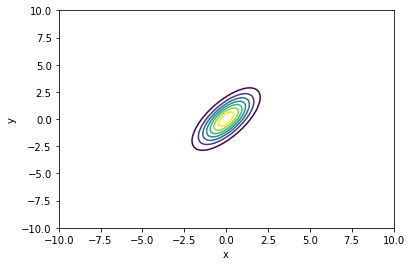

In [5]:
a_dist = HighDimensionalNormalLogPDF(2, 0.7)

levels = np.linspace(-10,10,10)
num_points = 100
x = np.linspace(-10, 10, num_points)
y = np.linspace(-10, 10, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[a_dist([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC
Differential Evolution MCMC
Population MCMC


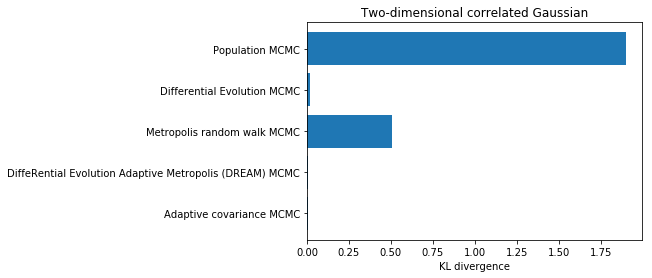

In [6]:
kls, names = run_samplers(a_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(kls)), kls)
plt.yticks(range(len(kls)), names)
plt.xlabel("KL divergence")
plt.title("Two-dimensional correlated Gaussian")
plt.show()

# Ten dimensional weakly-correlated Gaussian

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC


No handlers could be found for logger "pints._mcmc._differential_evolution"


Differential Evolution MCMC
Population MCMC


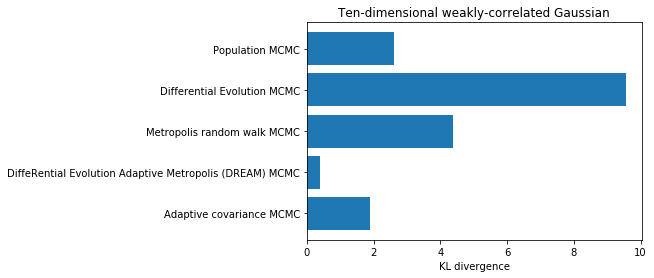

In [7]:
a_dist = HighDimensionalNormalLogPDF(10, 0.1)
kls, names = run_samplers(a_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(kls)), kls)
plt.yticks(range(len(kls)), names)
plt.xlabel("KL divergence")
plt.title("Ten-dimensional weakly-correlated Gaussian")
plt.show()

# Ten dimensional correlated Gaussian

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC
Differential Evolution MCMC
Population MCMC


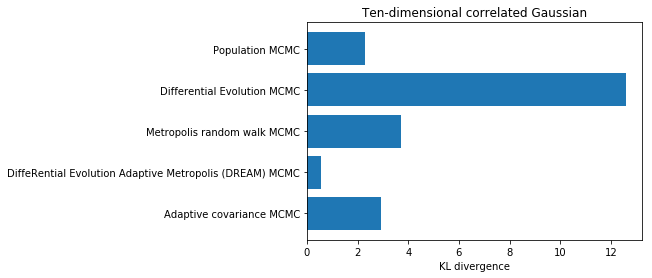

In [8]:
a_dist = HighDimensionalNormalLogPDF(10, 0.7)
kls, names = run_samplers(a_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(kls)), kls)
plt.yticks(range(len(kls)), names)
plt.xlabel("KL divergence")
plt.title("Ten-dimensional correlated Gaussian")
plt.show()

# Cone distributions. See answers to my question on here: https://mathematica.stackexchange.com/questions/182508/calculate-mean-and-variance-of-a-cone-shaped-distribution-in-n-dimensions#182512

In [184]:
class ConeNDLogPDF(pints.LogPDF):
    def __init__(self, dimensions=2):
        self._n_parameters = dimensions
    def __call__(self, x):
        return -np.linalg.norm(x)
    def n_parameters(self):
        return self._n_parameters
    def mean(self):
        return self._n_parameters
    def var(self):
        return self._n_parameters * (self._n_parameters + 1)

In [188]:
def run_samplers_cone(a_dist, samplers, samplesizes, n_chains):
    names = []
    mean_diff = np.zeros(len(samplers))
    for i, sampler in enumerate(samplers):
        x0 = np.zeros(a_dist.n_parameters()) + np.random.normal(0, 1, size=(n_chains, a_dist.n_parameters()))
        mcmc = pints.MCMCSampling(a_dist, n_chains, x0, method=sampler)
        mcmc.set_log_to_screen(False)
        mcmc.set_max_iterations(samplesizes[i])
        chains = mcmc.run()
        chains = chains[:, int(samplesizes[i] / 2):, :]
        chain = np.vstack(chains)
        d = map(lambda x: np.linalg.norm(x), chain)
        mean_diff[i] = 100 * np.abs(a_dist.mean() - np.mean(d)) / a_dist.mean()
        name = mcmc.samplers()[0].name()
        names.append(name)
        print(name)
    return mean_diff, names

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC
Differential Evolution MCMC
Population MCMC


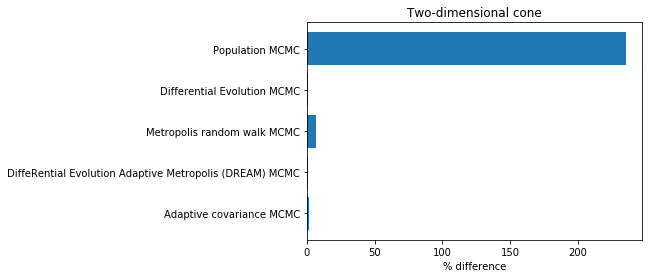

In [190]:
b_dist = ConeNDLogPDF()
mean_diff, names = run_samplers_cone(b_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(mean_diff)), mean_diff)
plt.yticks(range(len(mean_diff)), names)
plt.xlabel("% difference")
plt.title("Two-dimensional cone")
plt.show()

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC
Differential Evolution MCMC
Population MCMC


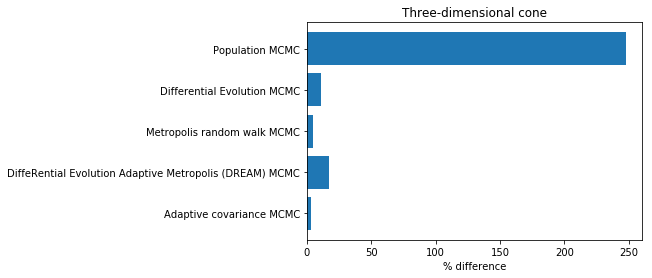

In [191]:
b_dist = ConeNDLogPDF(3)
mean_diff, names = run_samplers_cone(b_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(mean_diff)), mean_diff)
plt.yticks(range(len(mean_diff)), names)
plt.xlabel("% difference")
plt.title("Three-dimensional cone")
plt.show()

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC
Differential Evolution MCMC
Population MCMC


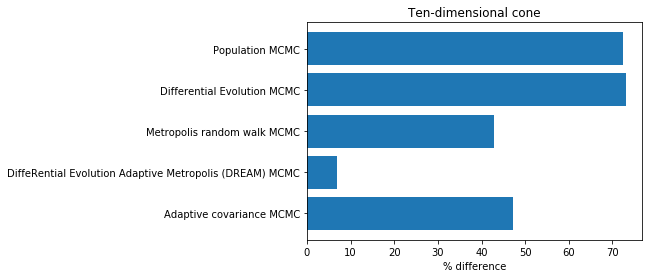

In [192]:
b_dist = ConeNDLogPDF(10)
mean_diff, names = run_samplers_cone(b_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(mean_diff)), mean_diff)
plt.yticks(range(len(mean_diff)), names)
plt.xlabel("% difference")
plt.title("Ten-dimensional cone")
plt.show()

# Cone distribution with arbitrarily fat tails (see my Mathematica for more general version of Stack exchange answer)

In [196]:
import scipy
class ConeLongtailedNDLogPDF(pints.LogPDF):
    def __init__(self, dimensions=2, beta=1):
        self._n_parameters = dimensions
        self._beta = beta
    def __call__(self, x):
        return -np.linalg.norm(x)**self._beta
    def n_parameters(self):
        return self._n_parameters
    def mean(self):
        return (scipy.special.gamma((1 + self._n_parameters) / self._beta) / 
                scipy.special.gamma(self._n_parameters / self._beta))
    def var(self):
        return (scipy.special.gamma((2 + self._n_parameters) / self._beta) / 
                scipy.special.gamma(self._n_parameters / self._beta))

In [199]:
c_dist = ConeLongtailedNDLogPDF(beta=0.5)
x0 = np.zeros(c_dist.n_parameters()) + np.random.normal(0, 1, size=(n_chains, c_dist.n_parameters()))
mcmc = pints.MCMCSampling(c_dist, n_chains, x0, method=pints.AdaptiveCovarianceMCMC)
mcmc.set_log_to_screen(False)
mcmc.set_max_iterations(samplesizes[0])
chains = mcmc.run()
chains = chains[:, int(samplesizes[0] / 2):, :]
chain = np.vstack(chains)
d = map(lambda x: np.linalg.norm(x), chain)

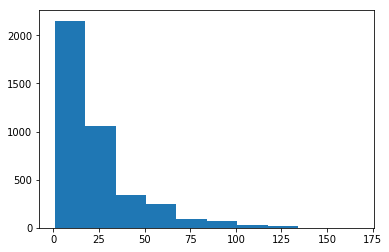

In [200]:
plt.hist(d)
plt.show()

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC
Differential Evolution MCMC
Population MCMC


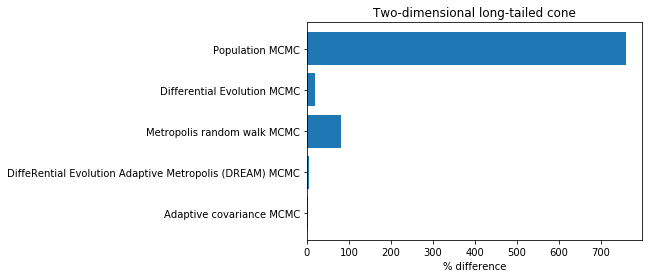

In [201]:
c_dist = ConeLongtailedNDLogPDF(beta=0.5)
mean_diff, names = run_samplers_cone(c_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(mean_diff)), mean_diff)
plt.yticks(range(len(mean_diff)), names)
plt.xlabel("% difference")
plt.title("Two-dimensional long-tailed cone")
plt.show()

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC
Differential Evolution MCMC
Population MCMC


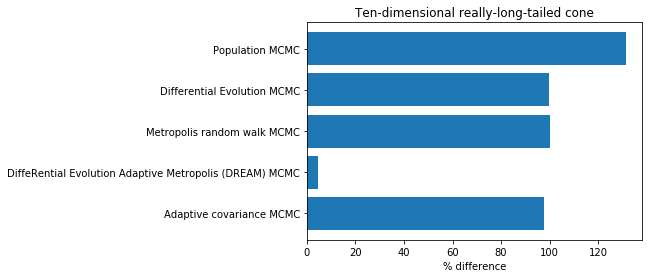

In [204]:
c_dist = ConeLongtailedNDLogPDF(dimensions=10, beta=0.25)
mean_diff, names = run_samplers_cone(c_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(mean_diff)), mean_diff)
plt.yticks(range(len(mean_diff)), names)
plt.xlabel("% difference")
plt.title("Ten-dimensional really-long-tailed cone")
plt.show()

# Mildly bimodal problems

In [9]:
class MultimodalNormalLogPDF(pints.LogPDF):
    """
    Multimodal (un-normalised) multivariate Normal distribution.

    By default, the distribution is on a 2-dimensional space, with modes at
    at ``(0, 0)`` and ``(10, 10)`` with independent unit covariance matrices.

    Examples::

        # Default 2d, bimodal
        f = pints.toy.MultimodalNormalLogPDF()

        # 3d bimodal
        f = pints.toy.MultimodalNormalLogPDF([[0, 1, 2], [10, 10, 10]])

        # 2d with 3 modes
        f = pints.toy.MultimodalNormalLogPDF([[0, 0], [5, 5], [5, 0]])

    Arguments:

    ``modes``
        A list of points that will form the modes of the distribution. Must all
        have the same dimension.
        If not set, the method will revert to the bimodal distribution
        described above.
    ``covariances``
        A list of covariance matrices, one for each mode. If not set, a unit
        matrix will be used for each.

    *Extends:* :class:`pints.LogPDF`.
    """
    def __init__(self, modes=None, covariances=None):

        # Check modes
        if modes is None:
            self._dimension = 2
            self._modes = [[0, 0], [10, 10]]
        else:
            if len(modes) < 1:
                raise ValueError(
                    'Argument `modes` must be `None` or a non-empty list of'
                    ' modes.')
            self._modes = [pints.vector(mode) for mode in modes]
            self._dimension = len(modes[0])
            for mode in self._modes:
                if len(mode) != self._dimension:
                    raise ValueError('All modes must have same dimension.')

        # Check covariances
        if covariances is None:
            self._covs = [np.eye(self._dimension)] * len(self._modes)
        else:
            if len(covariances) != len(self._modes):
                raise ValueError(
                    'Number of covariance matrices must equal number of'
                    ' modes.')
            self._covs = [np.array(cov, copy=True) for cov in covariances]
            for cov in self._covs:
                if cov.shape != (self._dimension, self._dimension):
                    raise ValueError(
                        'Covariance matrices must have shape (d, d), where d'
                        ' is the dimension of the given modes.')

        # Create scipy 'random variables'
        self._vars = [
            scipy.stats.multivariate_normal(mode, self._covs[i])
            for i, mode in enumerate(self._modes)]

    def __call__(self, x):
        f = np.sum([var.pdf(x) for var in self._vars])
        return -float('inf') if f == 0 else np.log(f)

    def n_parameters(self):
        """ See :meth:`pints.LogPDF.n_parameters()`. """
        return self._dimension
    
    def kl_divergence(self, samples):
        """
        Calculates a heuristic score for how well a given set of samples
        matches this LogPDF's underlying distribution, based on
        Kullback-Leibler divergence of the individual modes. This only works
        well if the modes are nicely separated, i.e. for larger values of
        ``r``.
        """
        # Separate into modes
        q1 = samples[samples[:, 1] <= -samples[:, 0]]
        q2 = samples[samples[:, 1] > -samples[:, 0]]
        qs = [q1, q2]
        dkls = np.array([0, 0], dtype=float)
        for i, q in enumerate(qs):
            if len(q) == 0:
                continue
            m0 = np.mean(q, axis=0)
            s0 = np.cov(q.T)
            m1 = self._modes[i]
            s1 = self._covs[i]
            cov_inv = np.linalg.inv(s1)
            dkl1 = np.trace(cov_inv.dot(s0))
            dkl2 = np.dot((m1 - m0).T, cov_inv).dot(m1 - m0)
            dkl3 = np.log(np.linalg.det(s1) / np.linalg.det(s0))
            dkls[i] = 0.5 * (dkl1 + dkl2 + dkl3 - 2)
        # No samples in a given quadrant? Then use 100 times max divergence
        penalty1 = 100 * np.max(dkls)
        dkls[dkls == 0] = penalty1

        # Sum divergences together
        score = np.sum(dkls)

        # Penalise unequal distribution of the points, and return
        ns = [len(q) for q in qs]
        penalty2 = np.max(ns) / max(1, np.min(ns))
        return score * penalty2

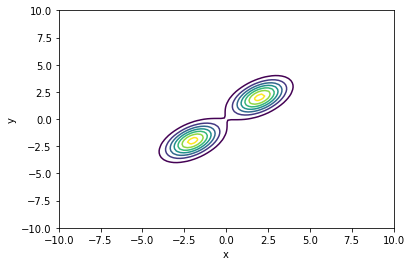

In [10]:
d_dist = MultimodalNormalLogPDF([[-2,-2],[2,2]],[[[1, 0.5],[0.5, 1]],[[1, 0.5],[0.5, 1]]])
num_points = 100
x = np.linspace(-10, 10, num_points)
y = np.linspace(-10, 10, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[d_dist([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

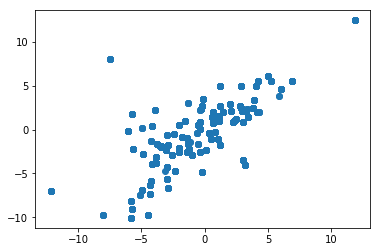

In [11]:
x0 = np.zeros(d_dist.n_parameters()) + np.random.normal(0, 1, size=(n_chains, d_dist.n_parameters()))
mcmc = pints.MCMCSampling(d_dist, n_chains, x0, method=pints.PopulationMCMC)
mcmc.set_log_to_screen(False)
mcmc.set_max_iterations(samplesizes[0])
chains = mcmc.run()
chains = chains[:, int(samplesizes[0] / 2):, :]
chain = np.vstack(chains)
plt.scatter(chain[:, 0], chain[:, 1])
plt.show()

### Separate into modes and calculate KL on each

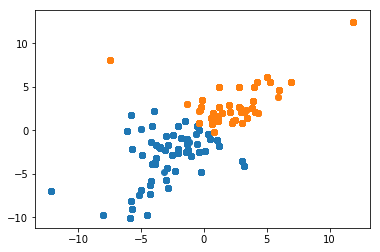

In [12]:
q1 = chain[chain[:, 1] <= -chain[:, 0]]
q2 = chain[chain[:, 1] > -chain[:, 0]]
plt.scatter(q1[:, 0], q1[:, 1])
plt.scatter(q2[:, 0], q2[:, 1])
plt.show()

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC
Differential Evolution MCMC
Population MCMC


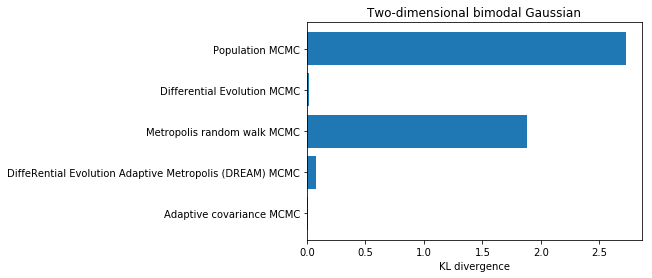

In [14]:
kls, names = run_samplers(d_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(kls)), kls)
plt.yticks(range(len(kls)), names)
plt.xlabel("KL divergence")
plt.title("Two-dimensional bimodal Gaussian")
plt.show()

## Look at single chain only for these bimodal problems

In [32]:
def run_samplers_single(a_dist, samplers, samplesizes, n_chains):
    names = []
    kls = np.zeros(len(samplers))
    for i, sampler in enumerate(samplers):
        x0 = np.zeros(a_dist.n_parameters()) + np.random.normal(0, 1, size=(n_chains, a_dist.n_parameters()))
        mcmc = pints.MCMCSampling(a_dist, n_chains, x0, method=sampler)
        mcmc.set_log_to_screen(False)
        mcmc.set_max_iterations(samplesizes[i])
        chains = mcmc.run()
        chains = chains[:, int(samplesizes[i] / 2):, :]
        chain = chains[0]
        kls[i] = a_dist.kl_divergence(chain)
        name = mcmc.samplers()[0].name()
        names.append(name)
        print(name)
    return kls, names

Adaptive covariance MCMC
DiffeRential Evolution Adaptive Metropolis (DREAM) MCMC
Metropolis random walk MCMC
Differential Evolution MCMC
Population MCMC


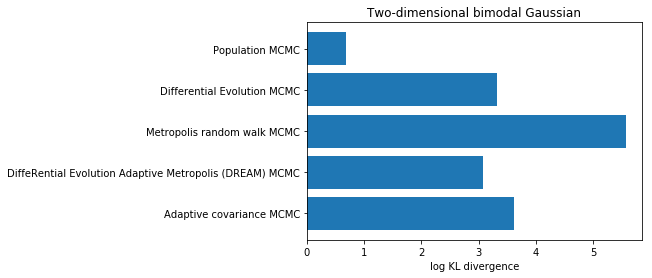

In [33]:
d_dist = MultimodalNormalLogPDF([[-10,-10],[10,10]],[[[1, 0.5],[0.5, 1]],[[1, 0.5],[0.5, 1]]])
kls, names = run_samplers_single(d_dist, samplers, samplesizes, n_chains)
plt.barh(range(len(kls)), np.log10(kls))
plt.yticks(range(len(kls)), names)
plt.xlabel("log KL divergence")
plt.title("Two-dimensional bimodal Gaussian")
plt.show()

# Neal's funnel

In [40]:
class NealFunnelLogPDF(pints.LogPDF):
    def __init__(self, dimensions=11):
        self._n_parameters = dimensions
    def __call__(self, x):
        nu = x[-1]
        x_log_pdf = [scipy.stats.norm.logpdf(y, 0, np.exp(-nu/2)) for y in x]
        return np.sum(x_log_pdf) + scipy.stats.norm.logpdf(nu, 0, 3)
    def n_parameters(self):
        return self._n_parameters

In [47]:
e_dist = NealFunnelLogPDF(7)

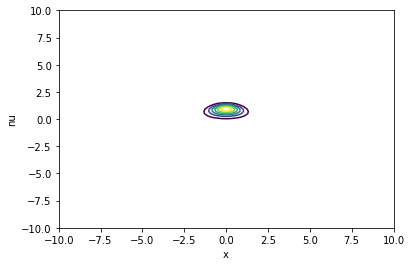

In [50]:
num_points = 100
x = np.linspace(-10, 10, num_points)
y = np.linspace(-10, 10, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[e_dist([i, 0, 0, 0, 0, 0, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('nu')
plt.show()

# Annulus distribution (another one I made up)

In [44]:
class AnnulusLogPDF(pints.LogPDF):
    def __init__(self, r0=10, sigma=1, dimensions=2):
        self._n_parameters = dimensions
        self._r0 = r0
        self._sigma = sigma
    def __call__(self, x):
        return scipy.stats.norm
    def n_parameters(self):
        return self._n_parameters
    def moment_normed(self, order):
        n = self._n_parameters
        alpha = order
        r0 = self._r0
        sigma = self._sigma
        front = 2**(2 - 0.5 * n + 0.5 * (-4 + n + alpha)) * np.exp(-r0**2 / (2 * sigma**2)) * sigma**(alpha)
        first_parenthesis = (np.sqrt(2) * sigma * scipy.special.gamma(0.5 * (n + alpha)) * 
                            scipy.special.hyp1f1(0.5 * (n + alpha), 0.5, r0**2 / (2 * sigma**2)) +
                            2 * r0 * scipy.special.gamma(0.5 * (1 + n + alpha)) *
                            scipy.special.hyp1f1(0.5 * (1 + n + alpha), 1.5, r0**2 / (2 * sigma**2)))
        denominator = (np.sqrt(2) * sigma * scipy.special.gamma(0.5 * n) * 
                       scipy.special.hyp1f1(0.5 * (1 - n), 0.5, -r0**2 / (2 * sigma**2)) +
                       2 * r0 * scipy.special.gamma(0.5 * (1 + n)) *
                       scipy.special.hyp1f1(1 - 0.5 * n, 1.5, -r0**2 / (2 * sigma**2)))
        return front * first_parenthesis / denominator
    def mean_normed(self):
        return self.moment_normed(1)
    def var_normed(self):
        a_mean = self.moment_normed(1)
        return self.moment_normed(2) - a_mean**2
    def sample(self, n_samples):
        # first sample values of r
        r = [self._reject_sample_r() for i in range(n_samples)]
        r = np.array(r)
        X_norm = np.random.normal(size=(n_samples, self._n_parameters))
        lambda_x = np.sqrt(np.sum(X_norm**2, axis=1))
        x_unit = [r[i] * X_norm[i] / y for i, y in enumerate(lambda_x)]
        return np.array(x_unit)
    def _reject_sample_r(self):
        r = np.random.normal(loc=self._r0, scale=self._sigma, size=1)
        while r < 0:
            r = np.random.normal(loc=self._r0, scale=self._sigma, size=1)
        return r

In [51]:
log_pdf = AnnulusLogPDF(r0=10, sigma=1, dimensions=2)
log_pdf.mean_normed()
log_pdf.var_normed()

0.99000000000020805

In [52]:
np.random.normal()

0.78280531175742

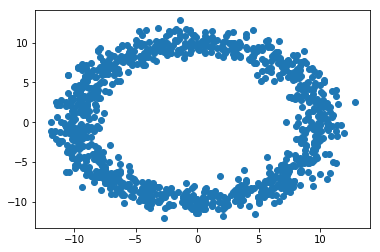

In [55]:
samples = log_pdf.sample(1000)
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()